In [1]:
%matplotlib inline
import sys, os, glob

from astropy.io import fits, ascii

import scipy.stats as st

import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
import astropy.constants as const
from astropy.coordinates import SkyCoord, concatenate
from astropy import table

In [21]:
#mode = 'optical+NIR+IR'
#mode = 'X+UV+optical+NIR+IR'
#mode = 'UV+optical+NIR+IR'
mode = 'optical+NIR'

#mode = 'X+UV+optical+NIR+IR+FIR'

In [13]:
import scienceplots

plt.style.use([ 'bright', 'science', 'no-latex', 'notebook'])

### Convert simulated photometry to new cigale input file

Regenerate the photometry for mock_analysis after running mock

In [4]:
dirpath = '/Volumes/"My Passport"'
pdirpath = '/Volumes/My Passport'

In [22]:
def replace_line(file_name, line_num, text):
    lines = open(file_name, 'r').readlines()
    lines[line_num] = text
    out = open(file_name, 'w')
    out.writelines(lines)
    out.close()

if mode == 'optical+NIR':
    bands = ['u_prime', 'g_prime', 'r_prime', 'i_prime', 'z_prime', 'vista.vircam.J', 'vista.vircam.H', 'vista.vircam.Ks']
if mode=='optical+NIR+IR':
    bands = ['u_prime', 'g_prime', 'r_prime', 'i_prime', 'z_prime', 'vista.vircam.J', 'vista.vircam.H', 'vista.vircam.Ks', 'IRAC1', 'IRAC2', 'IRAC3', 'IRAC4']
if mode=='UV+optical+NIR+IR':
    bands = ['galex.FUV', 'galex.NUV', 'u_prime', 'g_prime', 'r_prime', 'i_prime', 'z_prime', 'vista.vircam.J', 'vista.vircam.H', 'vista.vircam.Ks', 'IRAC1', 'IRAC2', 'IRAC3', 'IRAC4']
if mode=='X+UV+optical+NIR+IR':
    bands = ['xray_boxcar_0p5to10keV','galex.FUV', 'galex.NUV', 'u_prime', 'g_prime', 'r_prime', 'i_prime', 'z_prime', 'vista.vircam.J', 'vista.vircam.H', 'vista.vircam.Ks', 'IRAC1', 'IRAC2', 'IRAC3', 'IRAC4']
if mode=='X+UV+optical+NIR+IR+FIR':
    bands = ['xray_boxcar_0p5to10keV','galex.FUV', 'galex.NUV', 'u_prime', 'g_prime', 'r_prime', 'i_prime', 'z_prime', 'vista.vircam.J', 'vista.vircam.H', 'vista.vircam.Ks', 'IRAC1', 'IRAC2', 'IRAC3', 'IRAC4', 'herschel.pacs.70', 'herschel.pacs.100', 'herschel.pacs.160']

data_phot = []

# Replace bands in file
txt = 'bands = '+ ', '.join(bands) + '\n'

print(txt)

replace_line(f'{pdirpath}/cigale_mock_fit/float/pcigale.ini', 66, txt)
replace_line(f'{pdirpath}/cigale_mock_fit/fagn1/pcigale.ini', 66, txt)

# This is the simulated photometry file with all bands
hdul = fits.open(f'{pdirpath}/cigale_mock/float/out/models-block-0.fits')
mock_results = hdul[1].data

data_phot.append(list(range(len(mock_results))))
data_phot.append(np.full(len(mock_results), 0.0))

# Pick a subset of the bands to use for fitting on simulated photometry
print(bands)
for b in bands:
    data_phot.append(np.random.normal(mock_results[b], 0.1*mock_results[b])) # randomly sample 10% errors
    
data_phot = np.array(data_phot)
fmt = '%d ' + ' '.join(['%0.8f']*(len(bands) + 1))

hdr = 'id redshift '+' '.join(bands)

print('hdr:', len(hdr.split(',')))

# Save
np.savetxt(f'{pdirpath}/cigale_mock_fit/phot.dat', data_phot.T, header=hdr, fmt=fmt)
# g_prime, i_prime, r_prime, u_prime, vista.vircam.H, vista.vircam.J, vista.vircam.Ks, z_prime


bands = u_prime, g_prime, r_prime, i_prime, z_prime, vista.vircam.J, vista.vircam.H, vista.vircam.Ks

['u_prime', 'g_prime', 'r_prime', 'i_prime', 'z_prime', 'vista.vircam.J', 'vista.vircam.H', 'vista.vircam.Ks']
hdr: 1


``cd ./mock_analysis/float``

``pcigale run``

``cd ./mock_analysis/f_agn1``

``pcigale run``

### Mock analysis

In [256]:
str = f'{dirpath}/cigale_mock_fit/float/out_{mode}'
os.system(f'mv {dirpath}/cigale_mock_fit/float/out {str}')

str = f'{dirpath}/cigale_mock_fit/fagn1/out_{mode}'
os.system(f'mv {dirpath}/cigale_mock_fit/fagn1/out {str}')

0

In [23]:
# Plot output
hdul = fits.open(f'{pdirpath}/cigale_mock_fit/float/out_{mode}/results.fits')
results_float = hdul[1].data

hdul = fits.open(f'{pdirpath}/cigale_mock_fit/fagn1/out_{mode}/results.fits')
results_fagn1 = hdul[1].data

SF_excess = []
    
for i, row in enumerate(results_float): # Don't change this

    id = row['ID']

    # Make sure to update filename
    hdul = fits.open(f'{pdirpath}/cigale_mock_fit/float/out_{mode}/{id}_best_model.fits')
    data = hdul[1].data
    
    hdul = fits.open(f'{pdirpath}/cigale_mock_fit/fagn1/out_{mode}/{id}_best_model.fits')
    data_fagn1 = hdul[1].data

    #d_L = results_float['best.universe.luminosity_distance'][i]*u.m
    #toFnu = 1/(4*np.pi*d_L**2).to(u.m**2).value * data['wavelength'] / (const.c/(data['wavelength']*u.nm)).to(u.Hz).value * 1e3 * 1e26 # W / nm -> mJy
    # k-correction
    z = 0.0
    wave_RF = data['wavelength']*1e-3/(1 + z)
    
    mask = (wave_RF > 1.1) & (wave_RF < 1.3)
    #SF_excess.append(np.mean((galaxy*toFnu/data_fagn1['Fnu'])[mask]))
    SF_excess.append(np.mean((data['Fnu'][mask]/data_fagn1['Fnu'][mask])))
    
SF_excess = np.array(SF_excess)

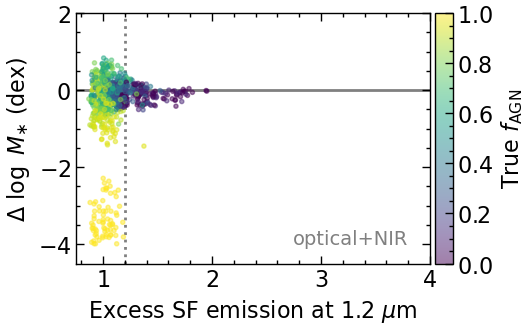

In [24]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Plot

mask_chi2 = (SF_excess > 1.2) & (results_float['best.reduced_chi_square'] < 5)

f_agn_in = mock_results['agn.fracAGN']
#f_agn_in = results_float['agn.fracAGN']

f_agn_in[f_agn_in==0.9999] = 1
f_agn_in[f_agn_in==0.001] = 0

dlog_m_star = np.log10(mock_results['stellar.m_star']) - np.log10(results_float['bayes.stellar.m_star'])


fig, axi = plt.subplots(1,1, figsize=(5.5, 3.5))

fagn1 = axi.scatter(SF_excess[(results_float['best.reduced_chi_square'] < 5)],
                    dlog_m_star[(results_float['best.reduced_chi_square'] < 5)],
                    marker='.', alpha=0.5, c=f_agn_in[(results_float['best.reduced_chi_square'] < 5)]) # type 1
    
# 
s1 = lambda x: np.percentile(x, 16)
s2 = lambda x: np.percentile(x, 84)

bins = np.linspace(-2, 6, 12) 
mean, bin_edges, _ = st.binned_statistic(SF_excess, dlog_m_star, statistic='mean', bins=bins)
std1, bin_edges, _ = st.binned_statistic(SF_excess, dlog_m_star, statistic=s1, bins=bins)
std2, bin_edges, _ = st.binned_statistic(SF_excess, dlog_m_star, statistic=s2, bins=bins)

#axi.plot(bin_edges[:-1] + np.diff(bin_edges)[0]/2, mean, marker='.', alpha=0.8, color='k', zorder=-1)
#axi.fill_between(bin_edges[:-1] + np.diff(bin_edges)[0]/2, std1, std2, alpha=0.25, color='k', zorder=-1)

axi.axhline(0, 0, 1, color='gray', zorder=-1)
axi.axvline(1.2, 0, 1, color='gray', zorder=-1, linestyle='dotted')

# Ax

axi.set_xlim(.75, 4)
axi.set_ylim(-4.5, 2)

divider = make_axes_locatable(axi)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(fagn1, cax=cax)
cax.set_ylabel(r'True $f_{\rm AGN}$')

axi.set_ylabel(r'$\Delta\ \log\ M_{\ast}$ (dex)')
axi.set_xlabel(r'Excess SF emission at $1.2\ \mu$m')

modet = mode.replace('+IR', '+MIR')
axi.text(3.8, -4, f'{modet}', fontsize=14, color='gray', ha='right')

fig.tight_layout()
fig.savefig(f'm_star_mock_{mode}.pdf', dpi=300)